In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from tqdm.auto import tqdm
import pandas as pd
import networkx as nx
import numpy as np

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_intervals import load_graphs
from src.pass_networks.pass_network import calculate_metrics 
from src.pass_networks.custom_metrics import calculate_average_path_legth_target
from src.pass_networks.custom_metrics import calculate_wasserstein_distance
from src.pass_networks.custom_metrics import calculate_modularity
from src.pass_networks.custom_metrics import calculate_graph_distance_stream
from src.pass_networks.process_match_info import get_match_info


# Get Graphs

In [5]:
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

In [6]:
players_info, teams_info, games_info = get_match_info(CSV_DATA_PATH)

In [7]:
games = os.listdir(PROCESSED_DATA_PATH)
game_ids = [game.split('.')[0] for game in games]
print(f"Games to process: {len(game_ids)}")

Games to process: 128


In [8]:
matches = []

for match_id in tqdm(game_ids, desc="Loading Graphs", total=len(game_ids)):
    match_graphs = load_graphs(match_id, PROCESSED_DATA_PATH)
    matches += match_graphs

Loading Graphs:   0%|          | 0/128 [00:00<?, ?it/s]

In [9]:
matches_df = pd.DataFrame(matches)
matches_df

,match_id,interval_id,team_id,graph
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)"
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)"
...,...,...,...,...
12619,4625,48.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
12620,4625,49.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"
12621,4625,49.0,221,"(-1, 24, 30, 16, 8, 1, 7, 22, 4, 15, 23, 31)"
12622,4625,50.0,16,"(-1, 2, 8, 17, 24, 10, 22, 6, 9, 23, 31, 7)"


# Graph Stream

In [10]:
selected_metrics = {
    "Density": nx.density,
    "Average Clustering": nx.average_clustering,
    "Betweenness Centrality": nx.betweenness_centrality,
    "Closeness Centrality": nx.closeness_centrality,
    "Average Path Length": calculate_average_path_legth_target,
}

In [11]:
for metric_name, metric_func in selected_metrics.items():
    matches_df[metric_name] = matches_df["graph"].apply(lambda x: metric_func(x))

    if "Centrality" in metric_name:
        matches_df[f'Average {metric_name}'] = matches_df[metric_name].apply(lambda x: np.mean(list(x.values())))


matches_df.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.131061,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.170396,inf
1,4436,1.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.089286,"{-1: 0.0, 17: 0.09090909090909091, 13: 0.0, 15...",0.040909,"{-1: 0.0, 17: 0.25252525252525254, 13: 0.0, 15...",0.152364,inf
2,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.018939,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.112170,1.714286
3,4436,2.0,7,"(-1, 17, 13, 15, 11, 9, 3, 10, 16, 28, 6, 22)",0.090909,0.126389,"{-1: 0.0, 17: 0.0, 13: 0.03636363636363636, 15...",0.040909,"{-1: 0.0, 17: 0.1818181818181818, 13: 0.192513...",0.136105,inf
4,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.091667,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.296537,inf


In [12]:
matches_df[['match_id','interval_id','team_id']]

,match_id,interval_id,team_id
0,4436,1.0,2
1,4436,1.0,7
2,4436,2.0,2
3,4436,2.0,7
4,4436,3.0,2
...,...,...,...
12619,4625,48.0,221
12620,4625,49.0,16
12621,4625,49.0,221
12622,4625,50.0,16


In [13]:
df_sorted = matches_df.sort_values(by=['match_id', 'team_id', 'interval_id']).reset_index(drop=True)
df_sorted.head()

,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.131061,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.170396,inf
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.018939,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.112170,1.714286
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.091667,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.296537,inf
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.125758,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.177494,2.600000
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.103788,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.241537,3.000000


In [14]:
# Lista para armazenar os resultados
distance_data = []

# Itera sobre os grupos de 'match_id' e 'team_id'
for (match_id, team_id), group in tqdm(df_sorted.groupby(['match_id', 'team_id']), desc="Calculating Distances", total=len(df_sorted.groupby(['match_id', 'team_id']))):
    # Ordena o grupo por 'interval_id'
    group = group.sort_values(by='interval_id').reset_index(drop=True)
    # Itera sobre os pares de grafos consecutivos
    for i in range(len(group) - 1):
        current_row = group.iloc[i]
        next_row = group.iloc[i + 1]
        # Verifica se os 'interval_id' são consecutivos
        distances = {'match_id': match_id, 'team_id': team_id, 'interval_id': i+1}
        G1 = current_row['graph']
        G2 = next_row['graph']

        # Calcula cada métrica de distância
        distances['distance'] = calculate_wasserstein_distance(G1, G2)
        distance_data.append(distances)

# Cria o novo DataFrame com as métricas de distância
df_distances = pd.DataFrame(distance_data)
df_distances

Calculating Distances:   0%|          | 0/256 [00:00<?, ?it/s]

,match_id,team_id,interval_id,distance
0,4436,2,1,0.666667
1,4436,2,2,2.166667
2,4436,2,3,1.833333
3,4436,2,4,0.666667
4,4436,2,5,0.666667
...,...,...,...,...
12363,4625,221,45,1.500000
12364,4625,221,46,0.166667
12365,4625,221,47,0.333333
12366,4625,221,48,0.500000


# Concept Drift

In [15]:
import numpy as np

In [16]:
drift_stream_df = df_distances.groupby(['match_id', 'interval_id']).agg(
    sum_distance=('distance', 'sum')
).reset_index()
drift_stream_df

,match_id,interval_id,sum_distance
0,4436,1,1.000000
1,4436,2,3.833333
2,4436,3,2.166667
3,4436,4,1.166667
4,4436,5,1.333333
...,...,...,...
6179,4625,45,3.000000
6180,4625,46,1.500000
6181,4625,47,1.000000
6182,4625,48,1.500000


In [17]:
from src.concept_drift.drift_points import detect_kswin_drift
import numpy as np

In [18]:
drift_points = []
for match_id in tqdm(drift_stream_df['match_id'].unique(), desc="Drift Analysis", total=len(drift_stream_df['match_id'].unique())):
    match_df = drift_stream_df[drift_stream_df['match_id'] == match_id].reset_index(drop=True)

    drift_avg = match_df['sum_distance'].tolist()

    kswin_drift_points = detect_kswin_drift(drift_avg, a=0.1,ws=6,ss=3,seed=42)

    drift_points.append({
        'match_id': int(match_id),
        'drift_points': kswin_drift_points,
    })
    
drift_df = pd.DataFrame(drift_points)
drift_df.head()

Drift Analysis:   0%|          | 0/128 [00:00<?, ?it/s]

,match_id,drift_points
0,4436,"[9, 24]"
1,4438,"[22, 31]"
2,4439,"[11, 22, 35, 41]"
3,4440,"[9, 15, 29, 37, 43]"
4,4441,"[22, 42]"


In [19]:
drift_df['drifts'] = drift_df['drift_points'].apply(lambda x: len(x))
drift_df.head()

,match_id,drift_points,drifts
0,4436,"[9, 24]",2
1,4438,"[22, 31]",2
2,4439,"[11, 22, 35, 41]",4
3,4440,"[9, 15, 29, 37, 43]",5
4,4441,"[22, 42]",2


In [20]:
media_drifts = drift_df['drifts'].mean()
media_drifts

np.float64(3.1328125)

In [23]:
df_exploded = drift_df.explode('drift_points')
df_exploded = df_exploded.dropna().reset_index(drop=True)
df_exploded['drift_points'] = df_exploded['drift_points'].astype(int)
df_exploded.head()

,match_id,drift_points,drifts
0,4436,9,2
1,4436,24,2
2,4438,22,2
3,4438,31,2
4,4439,11,4


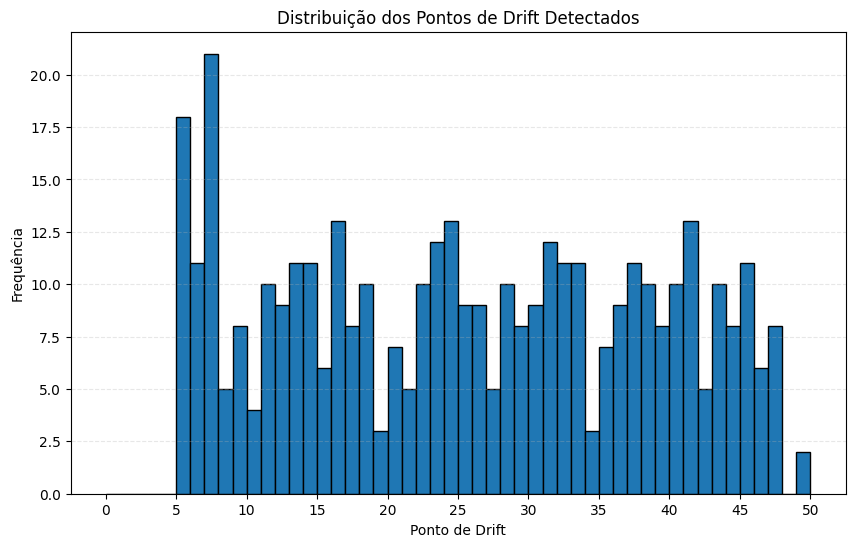

In [27]:
# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.hist(df_exploded['drift_points'], bins=range(0, 51), edgecolor='black')
plt.title('Distribuição dos Pontos de Drift Detectados')
plt.xlabel('Ponto de Drift')
plt.ylabel('Frequência')
plt.xticks(range(0, 51, 5))
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [29]:
drift_exploded = drift_df.explode('drift_points').reset_index(drop=True)

# Adicionar um ponto inicial 0 para facilitar a criação de intervalos
drift_exploded['start_point'] = drift_exploded.groupby('match_id')['drift_points'].shift(1).fillna(0).astype(int)
drift_exploded = drift_exploded.rename(columns={'drift_points': 'end_point'})

# Definir a fase com base nos intervalos
drift_exploded['fase'] = drift_exploded.groupby('match_id').cumcount() + 1

# Função para mapear interval_id para a fase correspondente
def get_fase(row, intervals):
    for _, interval in intervals.iterrows():
        if interval['start_point'] < row['interval_id'] <= interval['end_point']:
            return interval['fase']
    return len(intervals) + 1  # Caso o interval_id seja maior que todos os pontos de drift

# Aplicar a função para mapear as fases
df_sorted['phase'] = df_sorted.apply(lambda row: get_fase(row, drift_exploded[drift_exploded['match_id'] == row['match_id']]), axis=1)
df_sorted.head()

C:\Users\jllgo\AppData\Local\Temp\ipykernel_55284\1413752109.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  drift_exploded['start_point'] = drift_exploded.groupby('match_id')['drift_points'].shift(1).fillna(0).astype(int)


,match_id,interval_id,team_id,graph,Density,Average Clustering,Betweenness Centrality,Average Betweenness Centrality,Closeness Centrality,Average Closeness Centrality,Average Path Length,phase
0,4436,1.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.106061,0.000000,"{-1: 0.0, 35: 0.14545454545454545, 9: 0.0, 34:...",0.131061,"{-1: 0.0, 35: 0.3232323232323232, 9: 0.1888111...",0.170396,inf,1
1,4436,2.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.075758,0.062500,"{-1: 0.0, 35: 0.09999999999999999, 9: 0.009090...",0.018939,"{-1: 0.2727272727272727, 35: 0.204545454545454...",0.112170,1.714286,1
2,4436,3.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.174242,0.242645,"{-1: 0.0, 35: 0.10454545454545452, 9: 0.081818...",0.091667,"{-1: 0.0, 35: 0.43315508021390375, 9: 0.409090...",0.296537,inf,1
3,4436,4.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.090909,0.058532,"{-1: 0.0, 35: 0.39999999999999997, 9: 0.127272...",0.125758,"{-1: 0.28321678321678323, 35: 0.34224598930481...",0.177494,2.600000,1
4,4436,5.0,2,"(-1, 35, 9, 34, 11, 7, 1, 5, 8, 6, 12, 4)",0.121212,0.129299,"{-1: 0.0, 35: 0.13636363636363635, 9: 0.099999...",0.103788,"{-1: 0.27548209366391185, 35: 0.33471074380165...",0.241537,3.000000,1


# Characterize Phases

In [30]:
df_sorted.replace([np.inf, -np.inf], np.nan, inplace=True)

In [31]:
df_grouped = df_sorted.groupby(['match_id', 'team_id', 'phase']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
df_grouped.rename(columns={'Density': 'Average Density'}, inplace=True)
df_grouped.head()

,match_id,team_id,phase,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,4436,2,1,0.105219,0.146248,0.067929,0.171821,2.438095
1,4436,2,2,0.054040,0.065347,0.019192,0.080336,1.000000
2,4436,2,3,0.032513,0.023035,0.009217,0.043896,1.000000
3,4436,7,1,0.045455,0.033995,0.013721,0.065727,NaN
4,4436,7,2,0.064141,0.053361,0.026768,0.094263,1.843750


# Viz Drift Detection

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_match_segmentation(match_id, diff_series, drift_points, metric_series1, metric_series2, metric_name, team_names=None, team_colors=None):
    """
    Plota a segmentação de uma partida com base em uma métrica fornecida, destacando os pontos de drift.

    Parâmetros:
    - match_id: ID da partida.
    - diff_series: Série de diferenças (por exemplo, soma das distâncias).
    - drift_points: Pontos de drift identificados.
    - metric_series1: Série da métrica para o Time 1.
    - metric_series2: Série da métrica para o Time 2.
    - metric_name: Nome da métrica a ser plotada.
    - team_names: Lista opcional com os nomes dos times [nome_time1, nome_time2].
    - team_colors: Lista opcional com as cores para os times [cor_time1, cor_time2].
    """
    plt.figure(figsize=(20, 5))

    # Plotar a métrica para o Time 1
    plt.plot(metric_series1, label=f'{team_names[0]} - {metric_name}' if team_names else f'Time 1 - {metric_name}', color=team_colors[0] if team_colors else 'blue')

    # Plotar a métrica para o Time 2
    plt.plot(metric_series2, label=f'{team_names[1]} - {metric_name}' if team_names else f'Time 2 - {metric_name}', color=team_colors[1] if team_colors else 'green')

    # Adicionar linhas verticais nos pontos de drift
    for point in drift_points:
        plt.axvline(x=point, color='red', linestyle='--')

    # Configurações adicionais do gráfico
    plt.xticks(np.arange(0, len(metric_series1), step=2))
    plt.title(f"Segmentação da Partida {match_id} - {metric_name}")
    plt.legend()
    plt.ylim(0, max(max(metric_series1), max(metric_series2)) + 0.1)
    plt.xlabel('Intervalo de Tempo')
    plt.ylabel(f'Valor de {metric_name}')
    plt.grid(False)
    plt.show()

In [33]:
for match in drift_points[:10]:
    match_id = match['match_id']
    drift_pts = match['drift_points']

    df_match = df_sorted[df_sorted['match_id'] == match_id].reset_index(drop=True)
    df_match = df_match[['match_id', 'team_id', 'phase','interval_id']].merge(df_grouped, on=['match_id', 'team_id', 'phase'], how='left')

    team_ids = df_match['team_id'].unique()

    # Selecionar a métrica desejada
    metric_name = 'Density'
    metric_series1 = df_match[df_match['team_id'] == team_ids[0]][metric_name].tolist()
    metric_series2 = df_match[df_match['team_id'] == team_ids[1]][metric_name].tolist()

    # Supondo que diff_series seja uma coluna no DataFrame correspondente à soma das distâncias
    diff_series = df_match['sum_distance'] if 'sum_distance' in df_match.columns else None

    teams_info_match = teams_info[teams_info['team_id'].isin(team_ids)]
    team_names = teams_info_match['team_name'].tolist()

    plot_match_segmentation(
        match_id=match_id,
        diff_series=diff_series,
        drift_points=drift_pts,
        metric_series1=metric_series1,
        metric_series2=metric_series2,
        metric_name=metric_name,
        team_names=team_names,
        team_colors=['green', 'orange']
    )


KeyError: 'Density'

# Team Characterization

In [30]:
team_fase_metrics = df_sorted.groupby(['team_id', 'phase']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_fase_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
team_fase_metrics.head()

,team_id,phase,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,1,0.046532,0.033853,0.018008,0.067639,1.914086
1,1,2,0.042664,0.034888,0.014560,0.058398,1.156349
2,1,3,0.041390,0.031871,0.014582,0.059780,1.770736
3,1,4,0.029417,0.026129,0.005467,0.036208,1.216667
4,1,5,0.036240,0.025867,0.011807,0.051993,1.516026


In [32]:
fase_metrics = df_sorted.groupby(['phase']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
fase_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
fase_metrics.head()

,phase,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,0.058459,0.053983,0.023332,0.086973,1.742735
1,2,0.055035,0.052196,0.021906,0.082095,1.728646
2,3,0.051697,0.047311,0.020420,0.076904,1.758556
3,4,0.049750,0.047403,0.018795,0.073169,1.689729
4,5,0.044787,0.036752,0.016536,0.064765,1.571571


In [31]:
team_interval_metrics = df_sorted.groupby(['team_id', 'interval_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_interval_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
team_interval_metrics.head()

,team_id,interval_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,1.0,0.063763,0.058766,0.021780,0.094660,1.666667
1,1,2.0,0.025884,0.018510,0.007134,0.033832,NaN
2,1,3.0,0.037150,0.027083,0.017992,0.048119,NaN
3,1,4.0,0.036422,0.024151,0.008018,0.046691,2.222222
4,1,5.0,0.049242,0.049812,0.021275,0.074762,1.539683


In [38]:
team_metrics_avg_per_interval = df_sorted.groupby('team_id').agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_metrics_avg_per_interval.head()

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,0.040350,0.031361,0.013599,0.056524,1.551568
1,2,0.064568,0.067056,0.026845,0.099595,1.794075
2,3,0.050398,0.044279,0.020097,0.073536,1.824465
3,4,0.057797,0.056092,0.024459,0.087108,1.881016
4,6,0.062417,0.064940,0.025565,0.095563,1.786930


In [33]:
interval_metrics = df_sorted.groupby(['interval_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
interval_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
interval_metrics.head()

,interval_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1.0,0.067804,0.070752,0.025558,0.101305,1.314374
1,2.0,0.059853,0.051084,0.025250,0.089203,1.769812
2,3.0,0.058758,0.051584,0.022739,0.086868,1.689873
3,4.0,0.057940,0.051468,0.024752,0.086684,1.779054
4,5.0,0.058655,0.056078,0.024376,0.088617,1.916480


In [34]:
team_match_metrics = df_sorted.groupby(['team_id', 'match_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
team_match_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
team_match_metrics.head()

,team_id,match_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,1,4438,0.032762,0.013812,0.006538,0.040818,0.916667
1,1,4452,0.038925,0.032910,0.017662,0.058892,1.500000
2,1,4456,0.044509,0.034509,0.015750,0.065980,1.591667
3,1,4471,0.031605,0.027123,0.008286,0.040595,1.327778
4,1,4476,0.035862,0.025162,0.009839,0.047573,1.950000


In [35]:
match_metrics = df_sorted.groupby(['match_id']).agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()
match_metrics.rename(columns={'Density': 'Average Density'}, inplace=True)
match_metrics.head()

,match_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
0,4436,0.059161,0.059145,0.028826,0.091134,1.853831
1,4438,0.050932,0.038052,0.017583,0.072600,1.790889
2,4439,0.054350,0.034405,0.021772,0.079363,1.693470
3,4440,0.064424,0.063132,0.024602,0.097428,1.740260
4,4441,0.048131,0.047519,0.016259,0.065959,1.603475


# Viz Metrics

In [42]:

metric_columns = ['Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

# Aplicar a normalização Min-Max
team_metrics_normalized = team_metrics_avg_per_interval.copy()
team_metrics_normalized[metric_columns] = (team_metrics_avg_per_interval[metric_columns] - team_metrics_avg_per_interval[metric_columns].min()) / (team_metrics_avg_per_interval[metric_columns].max() - team_metrics_avg_per_interval[metric_columns].min())

team_metrics_normalized.sort_values(by='Density', ascending=False, inplace=True)

team_metrics_normalized.head()

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
9,11,1.000000,1.000000,1.000000,1.000000,1.000000
8,10,0.907578,0.818051,0.901544,0.888827,0.821650
1,2,0.653996,0.637913,0.644915,0.648298,0.706192
4,6,0.601700,0.604238,0.587919,0.593732,0.695169
13,17,0.507799,0.435480,0.506321,0.492713,0.740628


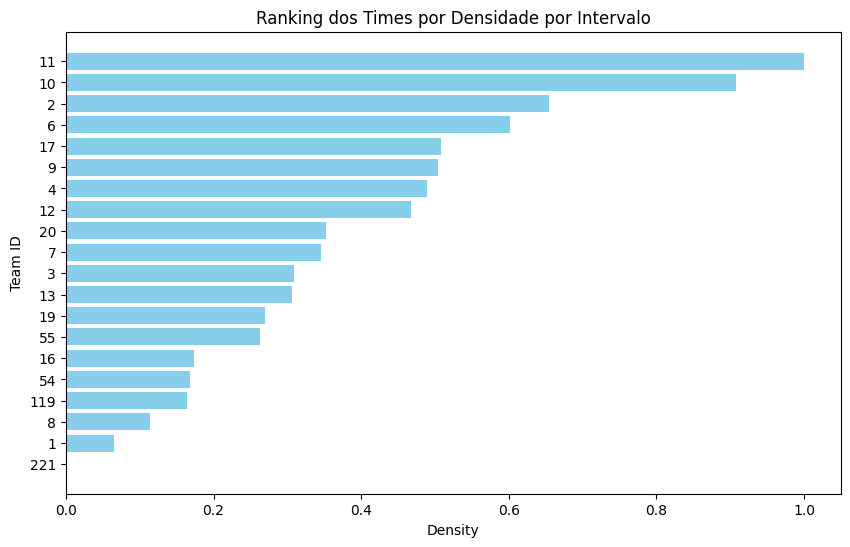

In [44]:
plt.figure(figsize=(10, 6))
plt.barh(team_metrics_normalized['team_id'].astype(str), team_metrics_normalized['Density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Team ID')
plt.title(f'Ranking dos Times por Densidade por Intervalo')
plt.gca().invert_yaxis()  # Inverter o eixo y para que o primeiro colocado fique no topo
plt.show()

In [48]:
fase_metrics_normalized = df_grouped.groupby('team_id').agg({
    'Average Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()

metric_columns = ['Average Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

fase_metrics_normalized[metric_columns] = (fase_metrics_normalized[metric_columns] - fase_metrics_normalized[metric_columns].min()) / (fase_metrics_normalized[metric_columns].max() - fase_metrics_normalized[metric_columns].min())

fase_metrics_normalized.sort_values(by='Average Density', ascending=False, inplace=True)

fase_metrics_normalized

,team_id,Average Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
9,11,1.000000,1.000000,1.000000,1.000000,1.000000
8,10,0.851729,0.823296,0.797572,0.820343,0.579820
1,2,0.597914,0.597152,0.590651,0.589535,0.599504
4,6,0.581945,0.640755,0.588936,0.575929,0.771005
13,17,0.474307,0.400928,0.483241,0.457042,0.580927
10,12,0.471952,0.488959,0.460433,0.452792,0.867729
3,4,0.462679,0.480527,0.489664,0.447160,0.793795
7,9,0.428492,0.402011,0.458004,0.415036,0.740031
15,20,0.342689,0.291055,0.332288,0.316108,0.476163
5,7,0.328107,0.289554,0.396749,0.316433,0.698037


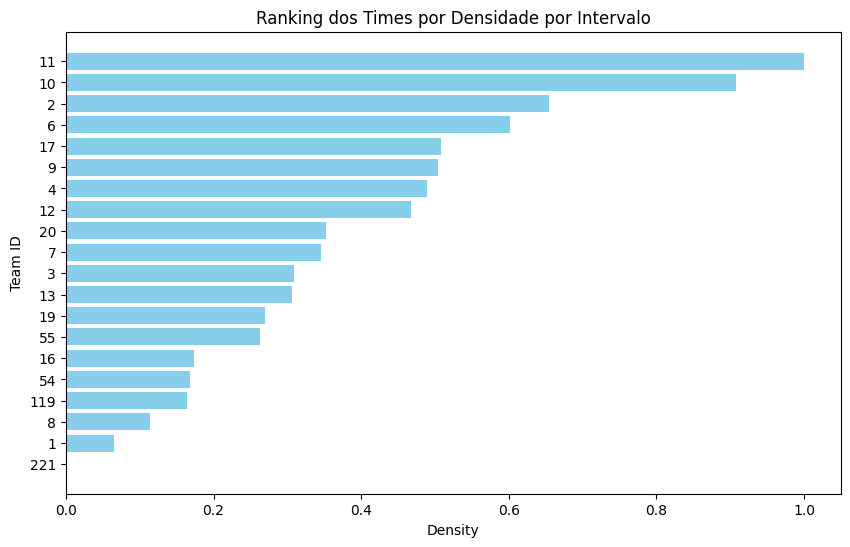

In [49]:
plt.figure(figsize=(10, 6))
plt.barh(team_metrics_normalized['team_id'].astype(str), team_metrics_normalized['Density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Team ID')
plt.title(f'Ranking dos Times por Densidade por Intervalo')
plt.gca().invert_yaxis()  # Inverter o eixo y para que o primeiro colocado fique no topo
plt.show()

In [54]:
#team_overall_avg = team_match_metrics.groupby('team_id').mean().reset_index()
team_overall_avg = team_match_metrics.groupby('team_id').agg({
    'Density': 'mean',
    'Average Clustering': 'mean',
    'Average Betweenness Centrality': 'mean',
    'Average Closeness Centrality': 'mean',
    'Average Path Length': 'mean'
}).reset_index()


metric_columns = ['Density', 'Average Clustering', 'Average Betweenness Centrality',
                  'Average Closeness Centrality', 'Average Path Length']

team_overall_avg[metric_columns] = (team_overall_avg[metric_columns] - team_overall_avg[metric_columns].min()) / (team_overall_avg[metric_columns].max() - team_overall_avg[metric_columns].min())

team_overall_avg.sort_values(by='Density', ascending=False, inplace=True)

team_overall_avg

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length
9,11,1.000000,1.000000,1.000000,1.000000,0.945031
8,10,0.905007,0.816467,0.899371,0.886619,1.000000
1,2,0.642946,0.629826,0.636061,0.638557,0.630911
4,6,0.606593,0.606878,0.591179,0.597670,0.338180
13,17,0.505532,0.433813,0.504067,0.490607,0.542441
3,4,0.504000,0.472122,0.549097,0.491347,0.578118
7,9,0.488726,0.467993,0.475719,0.470916,0.304108
10,12,0.456023,0.456132,0.462791,0.448354,0.564160
15,20,0.363102,0.304572,0.384180,0.346539,0.336361
5,7,0.343925,0.315277,0.428624,0.342575,0.242586


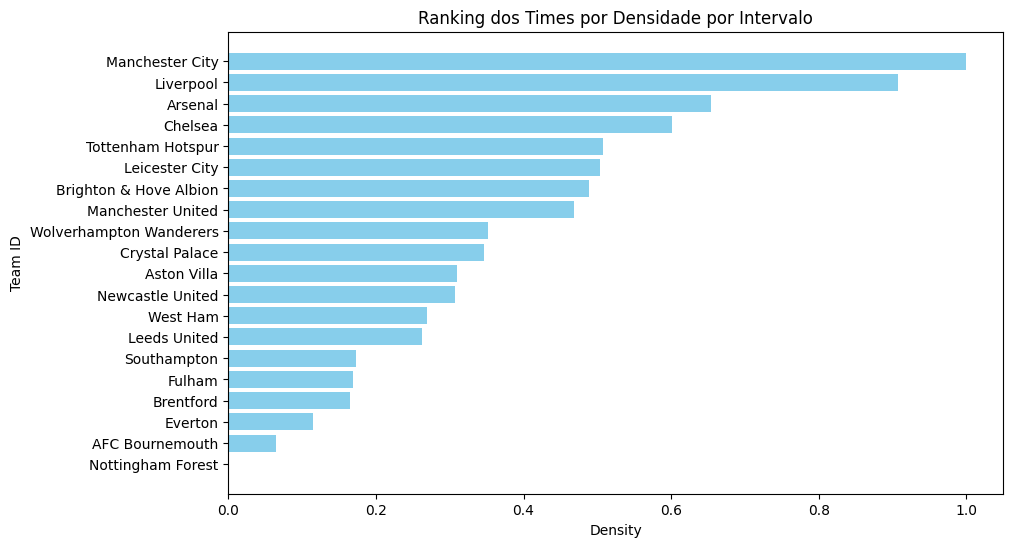

In [59]:
plt.figure(figsize=(10, 6))
team_metrics_normalized = team_metrics_normalized.merge(teams_info, on='team_id', how='left')
plt.barh(team_metrics_normalized['team_name'].astype(str), team_metrics_normalized['Density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Team ID')
plt.title(f'Ranking dos Times por Densidade por Intervalo')
plt.gca().invert_yaxis()  # Inverter o eixo y para que o primeiro colocado fique no topo
plt.show()

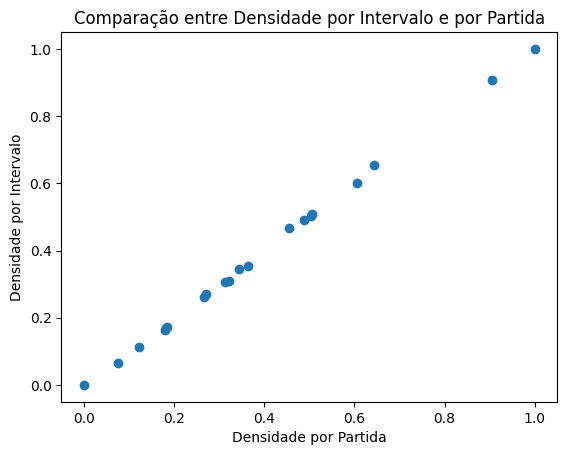

In [57]:
x = team_overall_avg['Density']  # Substitua 'Metrica1' pelo nome da primeira métrica
y = team_metrics_normalized['Density']  # Substitua 'Metrica2' pelo nome da segunda métrica
plt.scatter(x, y)
plt.title('Comparação entre Densidade por Intervalo e por Partida')
plt.xlabel('Densidade por Partida')
plt.ylabel('Densidade por Intervalo')
plt.show()


In [58]:
teams_info

,team_id,team_name,team_short_name,team_country,primary_color,secondary_color
0,1,AFC Bournemouth,BOU,England,#E20613,#000000
1,2,Arsenal,ARS,England,#E10B17,#FFFFFF
2,3,Aston Villa,AVL,England,#660E36,#93BDE4
3,4,Brighton & Hove Albion,BHA,England,#0A55A2,#FFFFFF
4,6,Chelsea,CHE,England,#184890,#1D1D1D
5,7,Crystal Palace,CRY,England,#DF2443,#3258A3
6,8,Everton,EVE,England,#0B478F,#FFFFFF
7,9,Leicester City,LCI,England,#233A80,#FFFFFF
8,10,Liverpool,LIV,England,#D01317,#FFFFFF
9,11,Manchester City,MCI,England,#6CABDD,#FFFFFF


In [61]:
metricas = ['Density', 'Average Clustering', 'Average Betweenness Centrality', 'Average Closeness Centrality', 'Average Path Length']

# Calcular o ranking para cada métrica
for metrica in metricas:
    coluna_ranking = metrica + ' Rank'
    team_metrics_normalized[coluna_ranking] = team_metrics_normalized[metrica].rank(ascending=False, method='min')

team_metrics_normalized

,team_id,Density,Average Clustering,Average Betweenness Centrality,Average Closeness Centrality,Average Path Length,team_name,team_short_name,team_country,primary_color,secondary_color,Density Rank,Average Clustering Rank,Average Betweenness Centrality Rank,Average Closeness Centrality Rank,Average Path Length Rank
0,11,1.000000,1.000000,1.000000,1.000000,1.000000,Manchester City,MCI,England,#6CABDD,#FFFFFF,1.0,1.0,1.0,1.0,1.0
1,10,0.907578,0.818051,0.901544,0.888827,0.821650,Liverpool,LIV,England,#D01317,#FFFFFF,2.0,2.0,2.0,2.0,4.0
2,2,0.653996,0.637913,0.644915,0.648298,0.706192,Arsenal,ARS,England,#E10B17,#FFFFFF,3.0,3.0,3.0,3.0,7.0
3,6,0.601700,0.604238,0.587919,0.593732,0.695169,Chelsea,CHE,England,#184890,#1D1D1D,4.0,4.0,4.0,4.0,8.0
4,17,0.507799,0.435480,0.506321,0.492713,0.740628,Tottenham Hotspur,TOT,England,#FFFFFF,#22274E,5.0,8.0,6.0,5.0,6.0
5,9,0.503794,0.478270,0.487217,0.483656,0.635176,Leicester City,LCI,England,#233A80,#FFFFFF,6.0,5.0,7.0,6.0,10.0
6,4,0.489361,0.463382,0.538694,0.479296,0.840322,Brighton & Hove Albion,BHA,England,#0A55A2,#FFFFFF,7.0,7.0,5.0,7.0,3.0
7,12,0.468179,0.464786,0.472430,0.458809,0.957063,Manchester United,MUN,England,#D91117,#221E20,8.0,6.0,8.0,8.0,2.0
8,20,0.352480,0.298801,0.377207,0.338031,0.596891,Wolverhampton Wanderers,WLV,England,#F59E1F,#000000,9.0,10.0,10.0,10.0,12.0
9,7,0.345812,0.316950,0.431479,0.344475,0.662817,Crystal Palace,CRY,England,#DF2443,#3258A3,10.0,9.0,9.0,9.0,9.0
